In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,symbol,open,high,low,close,volume,market,name,ranknow
date,,,,,,,,,
2013-04-28,BTC,135.30,135.98,132.10,134.21,0,1500520000,Bitcoin,1
2013-04-29,BTC,134.44,147.49,134.00,144.54,0,1491160000,Bitcoin,1
2013-04-30,BTC,144.00,146.93,134.05,139.00,0,1597780000,Bitcoin,1
2013-05-01,BTC,139.00,139.89,107.72,116.99,0,1542820000,Bitcoin,1
2013-05-02,BTC,116.38,125.60,92.28,105.21,0,1292190000,Bitcoin,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 658167 entries, 2013-04-28 to 2017-12-18
Data columns (total 9 columns):
symbol     658167 non-null object
open       658167 non-null float64
high       658167 non-null float64
low        658167 non-null float64
close      658167 non-null float64
volume     658167 non-null int64
market     658167 non-null int64
name       658167 non-null object
ranknow    658167 non-null int64
dtypes: float64(4), int64(3), object(2)
memory usage: 50.2+ MB


Hay demasiadas criptomonedas. Acá solo me enfocaré en Bitcoin. 

In [5]:
btc = df[df['symbol']=='BTC']  #Extraer los datos de Bitcoin 
btc.drop(['volume','symbol','name','ranknow','market'],axis=1,inplace=True) #Borramos las columnas que no necesitaremos

In [6]:
btc.isnull().any()  #No tenemos valores nulos

open     False
high     False
low      False
close    False
dtype: bool

In [7]:
#tenemos 1696 filas y 4 columnas
btc.shape

(1696, 4)

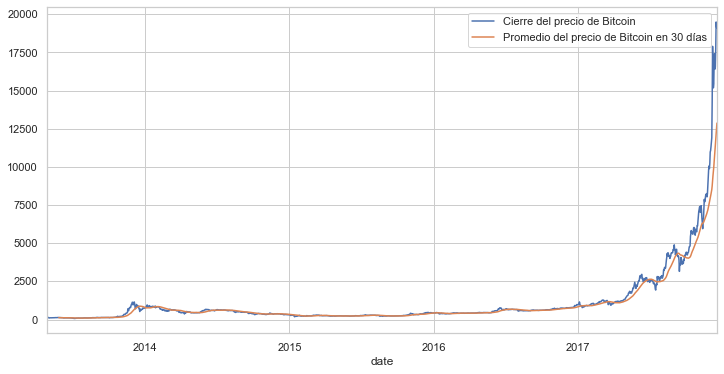

In [8]:
#Gráfica del promedio del precio en 30 días contra el precio de cierre.  ¡Enorme crecimiento del Bitcoin!

sns.set()
sns.set_style('whitegrid')
btc['close'].plot(figsize=(12,6), label='Cierre del precio de Bitcoin')
btc['close'].rolling(window=30).mean().plot(label='Promedio del precio de Bitcoin en 30 días')
plt.legend()

Predecir el comportamiento de Bitcoin dentro de un mes. 

In [9]:
#Agregaré una función para mejorar el modelo. Tafarel Yan proporciona esta función en su Kernel

btc['ohlc_average'] = (btc['open'] + btc['high'] + btc['low'] + btc['close']) / 4

In [10]:
btc.head()

,open,high,low,close,ohlc_average
date,,,,,
2013-04-28,135.30,135.98,132.10,134.21,134.3975
2013-04-29,134.44,147.49,134.00,144.54,140.1175
2013-04-30,144.00,146.93,134.05,139.00,140.9950
2013-05-01,139.00,139.89,107.72,116.99,125.9000
2013-05-02,116.38,125.60,92.28,105.21,109.8675


In [11]:
#Será nuestra variable-objetivo
btc['Price_After_Month']=btc['close'].shift(-30)

In [12]:
#Movimos todos nuestros valores 30 líneas en nuestra última columna.
btc.tail()

,open,high,low,close,ohlc_average,Price_After_Month
date,,,,,,
2017-12-14,16384.6,17085.8,16185.9,16564.0,16555.075,NaN
2017-12-15,16601.3,18154.1,16601.3,17706.9,17265.900,NaN
2017-12-16,17760.3,19716.7,17515.3,19497.4,18622.425,NaN
2017-12-17,19475.8,20089.0,18974.1,19140.8,19419.925,NaN
2017-12-18,19106.4,19371.0,18355.9,19114.2,18986.875,NaN


In [13]:
#Necesitamos escalar nuestros valores para ingresarlos en nuestro modelo

from sklearn import preprocessing

btc.dropna(inplace=True)
X=btc.drop('Price_After_Month', axis=1)
X=preprocessing.scale(X)
y=btc['Price_After_Month']

In [14]:
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=101)



In [15]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)
reg.fit(X_train,y_train)
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')   #Este porcentaje muestra cuánto se ajusta nuestra regresión a nuestros datos.

Accuracy is: 91.7867 %


In [16]:
#Podemos ver que nuestras predicciones son bastante precisas
preds = reg.predict(X_test)
print("The prediction is:",preds[1],"But the real value is:" ,y_test[1])

The prediction is: 607.1487500000002 But the real value is: 607.15


In [17]:
#Tomaremos los últimos 30 elementos para hacer nuestras predicciones sobre ellos.

X_30=X[-30:]
forecast=reg.predict(X_30)

In [18]:
#Creando una nueva columna que contiene las predicciones!

from datetime import datetime, timedelta
last_date=btc.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=30,freq='D')
df1=pd.DataFrame(forecast,columns=['Forecast'],index=date)
btc=btc.append(df1)
btc.tail()

,Forecast,Price_After_Month,close,high,low,ohlc_average,open
2017-12-14,15028.3660,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-15,12557.5675,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-16,18573.0780,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-17,18982.8710,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-18,18945.9850,NaN,NaN,NaN,NaN,NaN,NaN


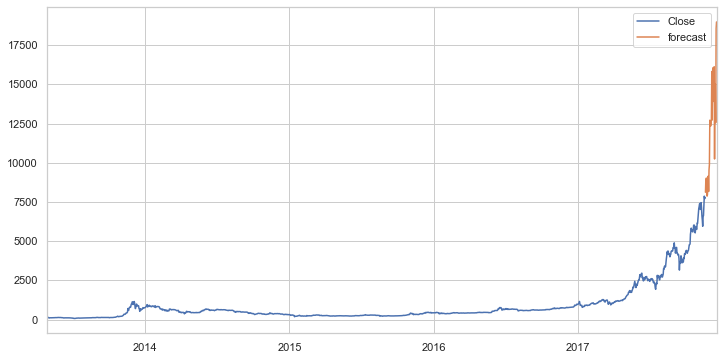

In [19]:
#¡Ahora trazaremos nuestro pronóstico!

btc['close'].plot(figsize=(12,6),label='Close')
btc['Forecast'].plot(label='forecast')
plt.legend()


¡Bitcoin costaba unos 18000 USD el 18 de diciembre y nuestro modelo predijo que sería de 18945 USD! Nada mal lograr esto con solo un modelo básico.